***Importing Libraries***

In [1]:
import time
start = time.time()

#Importing libraries:
import sqlite3 as sql
import seaborn as sns
import datetime
import gensim
import random
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#it helps the output of plotting commands is displayed inline in Jupyter notebook directly below the cell on which op was run.
import re
import pickle
end = time.time()
print('execution time is {:.3f} Minutes'.format(((end - start) / 60)))

execution time is 0.062 Minutes


In [2]:
import os

In [3]:
pwd

'/home/jalesh_j/Data_Preprocessing'

In [4]:
os.chdir('/home/jalesh_j/')

In [5]:
pwd

'/home/jalesh_j'

***uploading uncleaned database file for preprocessing***

In [6]:
#Using sqlite3 to retrieve data from sqlite file
start = time.time()
con = sql.connect("database.sqlite")#Connection object that represents the database

#Using pandas functions to query from sql table
df = pd.read_sql_query("""SELECT * FROM Reviews  where "Score" !=3 """,con)

#Reviews is the name of the table given
#Taking only the data where score != 3 as score 3 will be neutral and it won't help us much
df.head(2)
end = time.time()
print('execution time is {:.3f} Minutes'.format(((end - start) / 60)))

execution time is 0.104 Minutes


In [7]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
2     29769
Name: Score, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525814 entries, 0 to 525813
Data columns (total 10 columns):
Id                        525814 non-null int64
ProductId                 525814 non-null object
UserId                    525814 non-null object
ProfileName               525814 non-null object
HelpfulnessNumerator      525814 non-null int64
HelpfulnessDenominator    525814 non-null int64
Score                     525814 non-null int64
Time                      525814 non-null int64
Summary                   525814 non-null object
Text                      525814 non-null object
dtypes: int64(5), object(5)
memory usage: 40.1+ MB


CPU times: user 72 ms, sys: 16 ms, total: 88 ms
Wall time: 124 ms


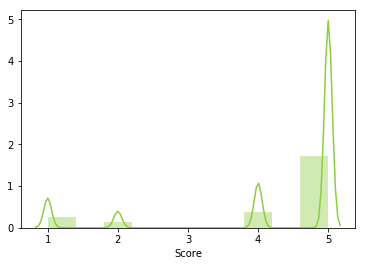

In [9]:
%%time
#to check the distibutions of the column 'Score'
sns.distplot(df['Score'], bins=10, color="#8ecc41")

In [10]:
#removing duplicates:
print(len(df))
df = df.drop_duplicates(subset=["UserId","ProfileName","Time","Text"], keep='first', inplace=False)

df = df[df.HelpfulnessNumerator <= df.HelpfulnessDenominator]
print(len(df))

525814
364171


In [11]:
# creating new dataframe consists of Summary, Time, Text and score:

d = df[['Score','Time', 'Text', 'Summary']]
print(d.columns)
print(len(d))

Index(['Score', 'Time', 'Text', 'Summary'], dtype='object')
364171


***Data Cleaning including removal of punctuation marks, html tags, lower text conversion etc***

In [12]:
%%time

# remove HTML TAG
d['Text'] = d['Text'].apply(lambda x : re.sub('<.*?>',' ', x))


#removing punctuation marks:
d['Text'] = d['Text'].apply(lambda x: re.sub(r'[?|!|\'|"|#|.|\,|)|(|\|/|:|-]', r' ', x))

#removing numerical values:
d['Text'] = d['Text'].apply(lambda x: re.sub(r'[0-9]', ' ', x))

#converting it to lower case:
d['Text'] = d['Text'].apply(lambda x: x.lower())

#removing http:
d['Text'] = d['Text'].apply(lambda x: re.sub(r'http\S+', r" ", x))

d['Text'] = d['Text'].apply(lambda x: re.sub(r"won't", "will not", x))
d['Text'] = d['Text'].apply(lambda x: re.sub(r"can\'t", "can not", x))

# general
d['Text'] = d['Text'].apply(lambda x: re.sub(r"n\'t", " not", x))
d['Text'] = d['Text'].apply(lambda x: re.sub(r"\'re", " are", x))
d['Text'] = d['Text'].apply(lambda x: re.sub(r"\'s", " is", x))
d['Text'] = d['Text'].apply(lambda x: re.sub(r"\'d", " would", x))
d['Text'] = d['Text'].apply(lambda x: re.sub(r"\'ll", " will", x))
d['Text'] = d['Text'].apply(lambda x: re.sub(r"\'t", " not", x))
d['Text'] = d['Text'].apply(lambda x: re.sub(r"\'ve", " have", x))
d['Text'] = d['Text'].apply(lambda x: re.sub(r"\'m", " am", x))    

CPU times: user 13.5 s, sys: 104 ms, total: 13.6 s
Wall time: 13.6 s


***Saving Numerical score for future purpose***

In [13]:
score = d['Score']
d['Score'] = d['Score'].apply(lambda x: 'positive' if int(x) > 3 else 'negative')
print(d['Score'].head(4))
print(d['Score'].value_counts())

0    positive
1    negative
2    positive
3    negative
Name: Score, dtype: object
positive    307061
negative     57110
Name: Score, dtype: int64


***Importing NLP libraries for stemming and stop words removal purpose***

In [14]:
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
snowstemmer = SnowballStemmer('english')


#removing some of the words in stopwords

stopwordset = set(stopwords.words('english')) #set of stopwords
stopwordlist = list(stopwordset)
temp = []
s = ''
for i in stopwordlist:
    if i in ('against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"):
        continue
    else:
        s = i
        temp.append(s)
stop = set(temp)

print(snowstemmer.stem('beautiful'))
print(stop)

beauti
{'am', 'should', 'so', 'as', 'in', 'for', 'more', 'our', 'each', 'where', 'whom', 'm', 'y', 'then', 'of', 'these', 'but', 'itself', 'her', 'most', 'my', 'do', 'have', 'about', 'further', 'over', 'theirs', "should've", 'before', 'he', 'down', 'themselves', 'herself', "she's", 'how', "you'll", 'very', 'why', 'their', 'hers', 's', 'is', 'during', 'yourselves', 'to', 'such', 've', 'doing', 'no', 'himself', 'and', 'was', 'o', 'some', 'them', 'out', 'those', 'ours', 'or', 'any', "that'll", 'below', 'can', 'does', 'be', 'which', 'will', 'only', 'here', 'the', 'when', 'who', 'they', 'through', 'an', 'now', 'd', 'other', "you're", 'too', 'just', 'this', 'what', 'between', 'myself', 'having', 'all', 'same', 'both', 'if', 't', 'that', 'after', 'there', 'shan', 'you', 'under', 'by', 'again', 'few', 'me', 'i', 'ourselves', 'off', 'while', 'a', 're', 'once', 'it', 'yours', 'until', 'ma', "you've", 'did', 'has', 'its', 'we', "you'd", 'above', 'your', 'up', 'nor', 'own', 'been', 'she', 'yoursel

***Main Preprocessing stage{including the list of of stemmed positive and negative reviews} -- for BoW***

In [15]:
%%time

final_string_list = []
positive_list = []
negative_list = []
i = 0
for sentence in d['Text'].values:
    filtered_sentence = []
    for word in sentence.split():
        if len(word) > 2 and word not in stop:
            char = snowstemmer.stem(word)
            filtered_sentence.append(char)
            if d['Score'].values[i] == 'positive':
                positive_list.append(char)
            else:
                negative_list.append(char)
        else:
            continue
            
        
    strings = ' '.join(filtered_sentence) #creating cleaned str object off list
    final_string_list.append(strings) # appending the cleaned string object inside list    
    i = i + 1      

CPU times: user 5min, sys: 1.34 s, total: 5min 1s
Wall time: 5min 1s


In [16]:
print(len(final_string_list))
print(final_string_list[0:2])

364171
['bought sever vital can dog food product found good qualiti product look like stew process meat smell better labrador finicki appreci product better', 'product arriv label jumbo salt peanut peanut actual small size unsalt not sure error vendor intend repres product jumbo']


In [17]:
d['cleanedtext'] = final_string_list
d['numeric_score'] = score
d['cleanedtext'].head(10)

0    bought sever vital can dog food product found ...
1    product arriv label jumbo salt peanut peanut a...
2    confect around centuri light pillowi citrus ge...
3    look secret ingredi robitussin believ found go...
4    great taffi great price wide assort yummi taff...
5    got wild hair taffi order five pound bag taffi...
6    saltwat taffi great flavor soft chewi candi in...
7    taffi good soft chewi flavor amaz would defini...
8    right most sprout cat eat grass love rotat aro...
9    healthi dog food good digest also good small p...
Name: cleanedtext, dtype: object

In [18]:
print(negative_list[1:10])
print()
print(positive_list[1:10])

['arriv', 'label', 'jumbo', 'salt', 'peanut', 'peanut', 'actual', 'small', 'size']

['sever', 'vital', 'can', 'dog', 'food', 'product', 'found', 'good', 'qualiti']


In [19]:
len(positive_list)

11867124

***checking and replacing NaN value of dataframe***

In [20]:
d[d.isnull().any(axis=1)]
# d.fillna('good', axis=1, inplace=True)
# d[d.isnull().any(axis=1)]

,Score,Time,Text,Summary,cleanedtext,numeric_score


# FeatureEngineering

***BoW - Feature Engineering***

In [21]:
#checking for whether any column is haivng Null value?
print(len(d))
print(d.isna().sum())

364171
Score            0
Time             0
Text             0
Summary          0
cleanedtext      0
numeric_score    0
dtype: int64


***data cleaning for 'Summary' column:***

In [22]:
%%time

# remove HTML TAG
d['Summary'] = d['Summary'].apply(lambda x : re.sub('<.*?>',' ', x))


#removing punctuation marks:
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r'[?|!|\'|"|#|.|\,|)|(|\|/|:|-]', r' ', x))

#removing numerical values:
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r'[0-9]', ' ', x))

#converting it to lower case:
d['Summary'] = d['Summary'].apply(lambda x: x.lower())

#removing http:
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r'http\S+', r" ", x))

d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"won't", "will not", x))
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"can\'t", "can not", x))

# general
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"n\'t", " not", x))
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'re", " are", x))
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'s", " is", x))
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'d", " would", x))
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'ll", " will", x))
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'t", " not", x))
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'ve", " have", x))
d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'m", " am", x))    

CPU times: user 11.4 s, sys: 28 ms, total: 11.4 s
Wall time: 11.4 s


In [23]:
d['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [24]:
%%time

final_string_list = []
positive_list = []
negative_list = []
i = 0
for sentence in d['Summary'].values:
    filtered_sentence = []
    for word in sentence.split():
        if len(word) > 2 and word not in stop:
            char = snowstemmer.stem(word)
            filtered_sentence.append(char)
            if d['Score'].values[i] == 'positive':
                positive_list.append(char)
            else:
                negative_list.append(char)
        else:
            continue
            
        
    strings = ' '.join(filtered_sentence) #creating cleaned str object off list
    final_string_list.append(strings) # appending the cleaned string object inside list    
    i = i + 1      

CPU times: user 22.4 s, sys: 20 ms, total: 22.4 s
Wall time: 22.4 s


In [26]:
d['bow_feat'] = final_string_list
d['bow_feat'].head(3)

0    good qualiti dog food
1             not advertis
2              delight say
Name: bow_feat, dtype: object

***BoW - Creating new featured column concatenation of 'Summary' and 'Text' columns***

In [28]:
# replacing blank space of one of the cells of 'summary' which is having NaN value:
#final_1L['Summary'] = final_1L['Summary'].replace(np.nan, '', regex=True)

#creating new column of concatenation of two columns:
d['bow_new_feat'] = d[['bow_feat', 'cleanedtext']].apply(lambda x: ' '.join(x),axis=1)
d['bow_new_feat'].head(2)

0    good qualiti dog food bought sever vital can d...
1    not advertis product arriv label jumbo salt pe...
Name: bow_new_feat, dtype: object

# W2V, TFidf - Feature engineering

In [29]:
d.isna().sum()

Score            0
Time             0
Text             0
Summary          0
cleanedtext      0
numeric_score    0
bow_feat         0
bow_new_feat     0
dtype: int64

In [32]:
# #removal of special characters etc.

# %%time

# # remove HTML TAG
# d['Summary'] = d['Summary'].apply(lambda x : re.sub('<.*?>',' ', x))


# #removing punctuation marks:
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r'[?|!|\'|"|#|.|\,|)|(|\|/|:|-]', r' ', x))

# #removing numerical values:
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r'[0-9]', ' ', x))

# #converting it to lower case:
# d['Summary'] = d['Summary'].apply(lambda x: x.lower())

# #removing http:
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r'http\S+', r" ", x))

# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"won't", "will not", x))
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"can\'t", "can not", x))

# # general
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"n\'t", " not", x))
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'re", " are", x))
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'s", " is", x))
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'d", " would", x))
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'ll", " will", x))
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'t", " not", x))
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'ve", " have", x))
# d['Summary'] = d['Summary'].apply(lambda x: re.sub(r"\'m", " am", x))    

In [31]:
d['Text'].head(3)

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
Name: Text, dtype: object

***Adding new column , concatenation of 'Summary' and 'Text' columns for TFidf & W2V***

In [34]:
d['tfw2v_feat'] = d[['Text', 'Summary']].apply(lambda x: ' '.join(x),axis=1)
d['tfw2v_feat'].head(5)

0    i have bought several of the vitality canned d...
1    product arrived labeled as jumbo salted peanut...
2    this is a confection that has been around a fe...
3    if you are looking for the secret ingredient i...
4    great taffy at a great price   there was a wid...
Name: tfw2v_feat, dtype: object

In [33]:
d['Summary'].head(9)

0                            good quality dog food
1                                not as advertised
2                             delight  says it all
3                                   cough medicine
4                                      great taffy
5                                       nice taffy
6    great   just as good as the expensive brands 
7                           wonderful  tasty taffy
8                                       yay barley
Name: Summary, dtype: object

***Saving the preprocessed dataframes onto disc for future assignment purposes***

In [35]:
#saving into database file:
con = sql.connect('/home/jalesh_j/Data_Preprocessing/cleaned.sqlite')
d.to_sql('cleandf', con, schema=None, if_exists='replace')

#saving into csv file:
d.to_csv('/home/jalesh_j/Data_Preprocessing/clean.csv')

#saving positive_reviews and negative reviews into seperate dataframes on disc:
pos = dict(positive_review_words = positive_list)
neg = dict(negative_review_words = negative_list)
positive = pd.DataFrame(pos)
negative = pd.DataFrame(neg)

positive.to_csv('/home/jalesh_j/Data_Preprocessing/positive_reviews_df')
negative.to_csv('/home/jalesh_j/Data_Preprocessing/negative_reviews_df')


In [36]:
# z = pd.read_csv('/home/jalesh_j/Data_Preprocessing/clean.csv')
# z.drop('Unnamed: 0', inplace=True, axis=1)
# print(z.head(4))

# #Using sqlite3 to retrieve data from sqlite file
# start = time.time()
# con = sql.connect('/home/jalesh_j/Data_Preprocessing/cleaned.sqlite')#Connection object that represents the database

# #Using pandas functions to query from sql table
# f = pd.read_sql_query("""SELECT * FROM cleandf """,con)